# Classification: Distances

Exploring euclidean distances between facial points caputred by nuiCapture as candidate features.
<p>
    <img src="nuicapture.png">
    <em>Source: CadavidConcepts</em>
</p>

In [1]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def labelname(file_name):  # Extract labels from filenames 
    label = file_name.replace("data/fundamental/sample", "").lower()
    label = label.replace(".mat", "").lower()
    label = label.split('-', 1)[-1]
    return label


class Signal:  # Signal representation containing x and y coordinates and corresponding label
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

## Dataset preparation

In [3]:
files = gl.glob("data/fundamental/*.mat")  # type: list
signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

nsigns = len(signals)
nrecs, nx = np.shape(signals[0].x)  # Number of recordings and number of features
nframes = 5

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {'angry': 1, 'disgusted': 2, 'fearful': 3, 'happy': 4, 'sad': 5, 'surprised': 6, 
               'neutral': 7, 'suckedcheeks': 8, 'inflatedcheeks': 9}  # Dictionary of signals' labels, for reference

points = [3,  6,  8,  9, 11, 16, 17, 20, 25, 32, 49, 50, 53, 58, 65, 91, 92]
points = np.array(points)
npoints = np.shape(points)[0]

frame_x = []
frame_y = []

for s in signals:
    frame_x.append(np.split(s.x, 5, axis=1))
    frame_y.append(np.split(s.y, 5, axis=1))
    signals_labels.append([labels_dict[s.label]] * nrecs)

frame_x = np.array(frame_x)
frame_y = np.array(frame_y)
new_frame_x = []
new_frame_y = []

for s in range(nsigns):
    new_frame_x.append(np.transpose(frame_x[s,:,:,points]))
    new_frame_y.append(np.transpose(frame_y[s,:,:,points]))

sig_features = np.empty((nrecs*nsigns, nframes*npoints*2))
sig_features[:,::2] = (np.vstack(new_frame_x)).reshape(nrecs*nsigns,npoints*5)
sig_features[:,1::2] = (np.vstack(new_frame_y)).reshape(nrecs*nsigns,npoints*5)

sig_labels = np.reshape(signals_labels, (nsigns * nrecs,))

np.savetxt("data/csv/distances-labels.csv",sig_labels,fmt='%i',delimiter=",")
np.savetxt("data/csv/distances.csv",sig_features,delimiter=",")

## Classification

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from pprint import pprint

In [5]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=800, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 0.3]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
              }

In [6]:
niter = 30
results = []
train_acc = []
test_acc = []
train_report =[]
class_report = []
selected_params = []
cm = [] # confusion matrix
feature_importance = []
col_names = range(1,1211)

for i in range(niter):
    print("Iteration:: ", i)
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    sss.get_n_splits(sig_features, sig_labels)

    for train_index, test_index in sss.split(sig_features, sig_labels):
        train_x, test_x = sig_features[train_index], sig_features[test_index]
        train_y, test_y = sig_labels[train_index], sig_labels[test_index]

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=500, cv=3, verbose=1, n_jobs=-1)

    rf_random.fit(train_x, train_y)
    predictions = rf_random.predict(test_x)
    
    selected_params.append(rf_random.best_params_)
    train_acc.append(accuracy_score(train_y, rf_random.predict(train_x)))
    test_acc.append(accuracy_score(test_y, predictions))
    cm.append(pd.crosstab(test_y, predictions, rownames=['True'], colnames=['Predicted'], margins=True))
    class_report.append(classification_report(test_y, predictions, target_names=list(labels_dict.keys())))
    feature_importance.append(pd.DataFrame(data=sorted(zip(map(lambda x: round(x, 4), 
                                                               rf_random.best_estimator_.feature_importances_), 
                                                           col_names), reverse=True)))

Iteration::  0
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  1
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.5min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  2
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  3
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.5min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  4
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.6min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  5
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  6
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  7
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  8
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  9
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  10
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.5min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  11
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.5min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  12
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 27.1min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  13
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.2min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  14
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  15
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.1min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  16
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.2min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  17
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 24.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  18
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.8min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  19
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  20
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.8min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  21
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.0min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  22
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  23
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  24
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  25
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.8min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  26
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  27
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  28
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 25.1min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  29
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 24.9min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


## Results

In [7]:
from functools import reduce

conf_matrix = reduce(lambda x, y: x.add(y, fill_value=0), cm)

np.savetxt("results/distances/dst-trainacc.csv",train_acc,delimiter=",")
np.savetxt("results/distances/dst-testacc.csv",test_acc,delimiter=",")
np.savetxt("results/distances/dst-selected_params.txt",selected_params,fmt='%s',delimiter='\n')
np.savetxt("results/distances/dst-classreport.txt",class_report,fmt='%s',delimiter='\n')
conf_matrix.to_csv("results/distances/dst-cm.csv")

import pickle
with open('results/distances/dst-featimportance.pickle', 'wb') as fp:
    for feat in feature_importance:
        pickle.dump(feat, fp)

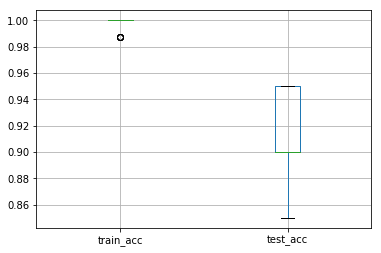

In [8]:
acc = np.transpose([train_acc, test_acc])
acc = pd.DataFrame(data=acc, columns=['train_acc', 'test_acc'])
boxplot = acc.boxplot(column=['train_acc', 'test_acc'])
plt.show()

In [9]:
acc.describe()

,train_acc,test_acc
count,30.000000,30.000000
mean,0.997917,0.913333
std,0.004738,0.029165
min,0.987500,0.850000
25%,1.000000,0.900000
50%,1.000000,0.900000
75%,1.000000,0.950000
max,1.000000,0.950000


In [ ]:
np.array(np.multiply(acc['test_acc'],100))

import matplotlib.pyplot as plt
%matplotlib notebook
acc_traj = pd.DataFrame(data=np.transpose([np.array(np.multiply(acc['test_acc'],100)), 
                                           [65,70,65,60,75,65,65,70,50,40,55,75,80,75,65,65,90,70,65,50,65,55,75,70,70,45,75,75,60,70], 
                                           [45,45,45,50,55,55,60,40,45,45,40,60,45,45,35,50,60,65,55,55,40,55,55,50,60,55,60,55,50,50]]), 
                                           columns=['RF', 'SVM', 'k-NN'])
boxplot_traj = acc_traj.boxplot(column=['RF', 'SVM', 'k-NN'], vert=False)
plt.show()